# Land Cover Continuous Monitoring Service (LC-CMS) - Data Access
<img src="./figs/lccms_pipeline.png" height="400"/>

This notebook contains information about accessing the data for LC-CMS use case.

The tutorial focusses on the accessing and visualizing the prediction results derived from the LC-CMS use case.
The results are also available on the Map Viewer which can be accessed using this **[link](https://www.globalearthmonitor.eu/sites/default/files/LC_CMS/index.html)**.

The predictions are stored in _[BYOC SentinelHub layers](https://docs.sentinel-hub.com/api/latest/data/byoc/)_. 
Here are the details of the layers and bands to access the data:

| **Layer**               | **Region** | **Resolution** | **SH Collection Id**                 | **Raster Band** |
| ----------------------- | ---------- | -------------- | ------------------------------------ | --------------- |
| LC-CMS Predictions      | France AOI | 120m           | 59b4de97-ad51-47b0-80f6-c6c47fae1ca7 | B1              |
| LC-CMS Predictions      | France AOI | 60m            | 84f1e9db-4abe-4ddf-8d00-17b2783531c4 | B1              |
| LC-CMS Predictions      | France AOI | 20m            | 5c21b111-07d2-43a3-95ad-46381c6e199a | B1              |
| LC-CMS Predictions 2019 | Africa AOI | 120m           | d90fec4d-b21b-4780-b0c5-20dc2d1017d4 | Y2019           |
| LC-CMS Predictions 2020 | Africa AOI | 120m           | d90fec4d-b21b-4780-b0c5-20dc2d1017d4 | Y2020           |
| LC-CMS Predictions 2021 | Africa AOI | 120m           | d90fec4d-b21b-4780-b0c5-20dc2d1017d4 | Y2021           |


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType
from eolearn.io import SentinelHubInputTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Predicitons over pilot Africa AOI
Following code snippets show how to access and visualize the predictions generated using LC-CMS pipeline. </br>
</br>
The predictions were generated using following input data and modelling technique : </br>

**Input Data**
- Sentinel-2 L2A : Bands B1 to B12
- 120m with bilinear resampling​
- Sub-regions (AOIs) with different biomes and geographies 
- Yearly data aggregated every two months
- Predictions generated yearly

**Model**
- Pixel Based Classification using Random Forest Classifier
- 9 Classes

Additionaly, LC-Classes are represented by following values in the prediction array <br/>
| **Land Cover Class** | **Value** |
| -------------------- | --------- |
| Forest               |    1      |
| Grass                |    3      |
| Farmland             |    4      |
| Bare Soil            |    6      |
| Sand                 |    7      |
| Built-Up             |    8      |
| Permanent Water      |    9      |
| Intermittent Water   |    10     |
| Eternal Snow         |    11     |

In [2]:
# The data for three years are stored as separate bands with following band names
band_names = ["Y2019", "Y2020", "Y2021"]

lcms_preds_byoc = DataCollection.define_byoc(
    "d90fec4d-b21b-4780-b0c5-20dc2d1017d4",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

In [3]:
# Create a task that will download the data from the BYOC service
predictions_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "lcms_pred"),
    data_collection=lcms_preds_byoc,
    bands=band_names,
    resolution=120,
    max_threads=3,
)

In [4]:
nigeria_bbox = BBox((643000.0, 1105000.0, 715000.0, 1175000.0), CRS.UTM_31N)
eopatch = predictions_download_task.execute(bbox=nigeria_bbox) #, time_interval=["2019-01-01", "2023-01-01"]

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'lcms_pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


## Visualizing LC-Classes
For visualization, LC classes are represented using different colors on the map shown here:
<!-- !["figs/lcms_display.PNG"](./figs/lcms_display.png) -->
<img src="./figs/lcms_display.png" width="150"/>

In [5]:
# This function will be used to visualize the data as RGB image, The Color mapping is shown above.
def transform_to_rgb(preds):
    """
    Function to transform the predictions to RGB for visualization
    """
    ids_to_rgb = {0: [0, 0, 0], 1: [23, 91, 55], 3: [178, 223, 186], 4: [72, 234, 37], 6: [243, 245, 234], 7: [254, 247, 180], 8: [245, 42, 5], 9: [50, 74, 221], 10: [140, 203, 255], 11: [111, 124, 128]}
    resulr_arr = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)
    for id, mapping in ids_to_rgb.items():
        resulr_arr[np.where(preds == id)] = np.array(mapping)
    return resulr_arr

Text(0.5, 0.9, 'LCMS Predictions for Kainji Lake, Nigeria in the pilot AOI Africa')

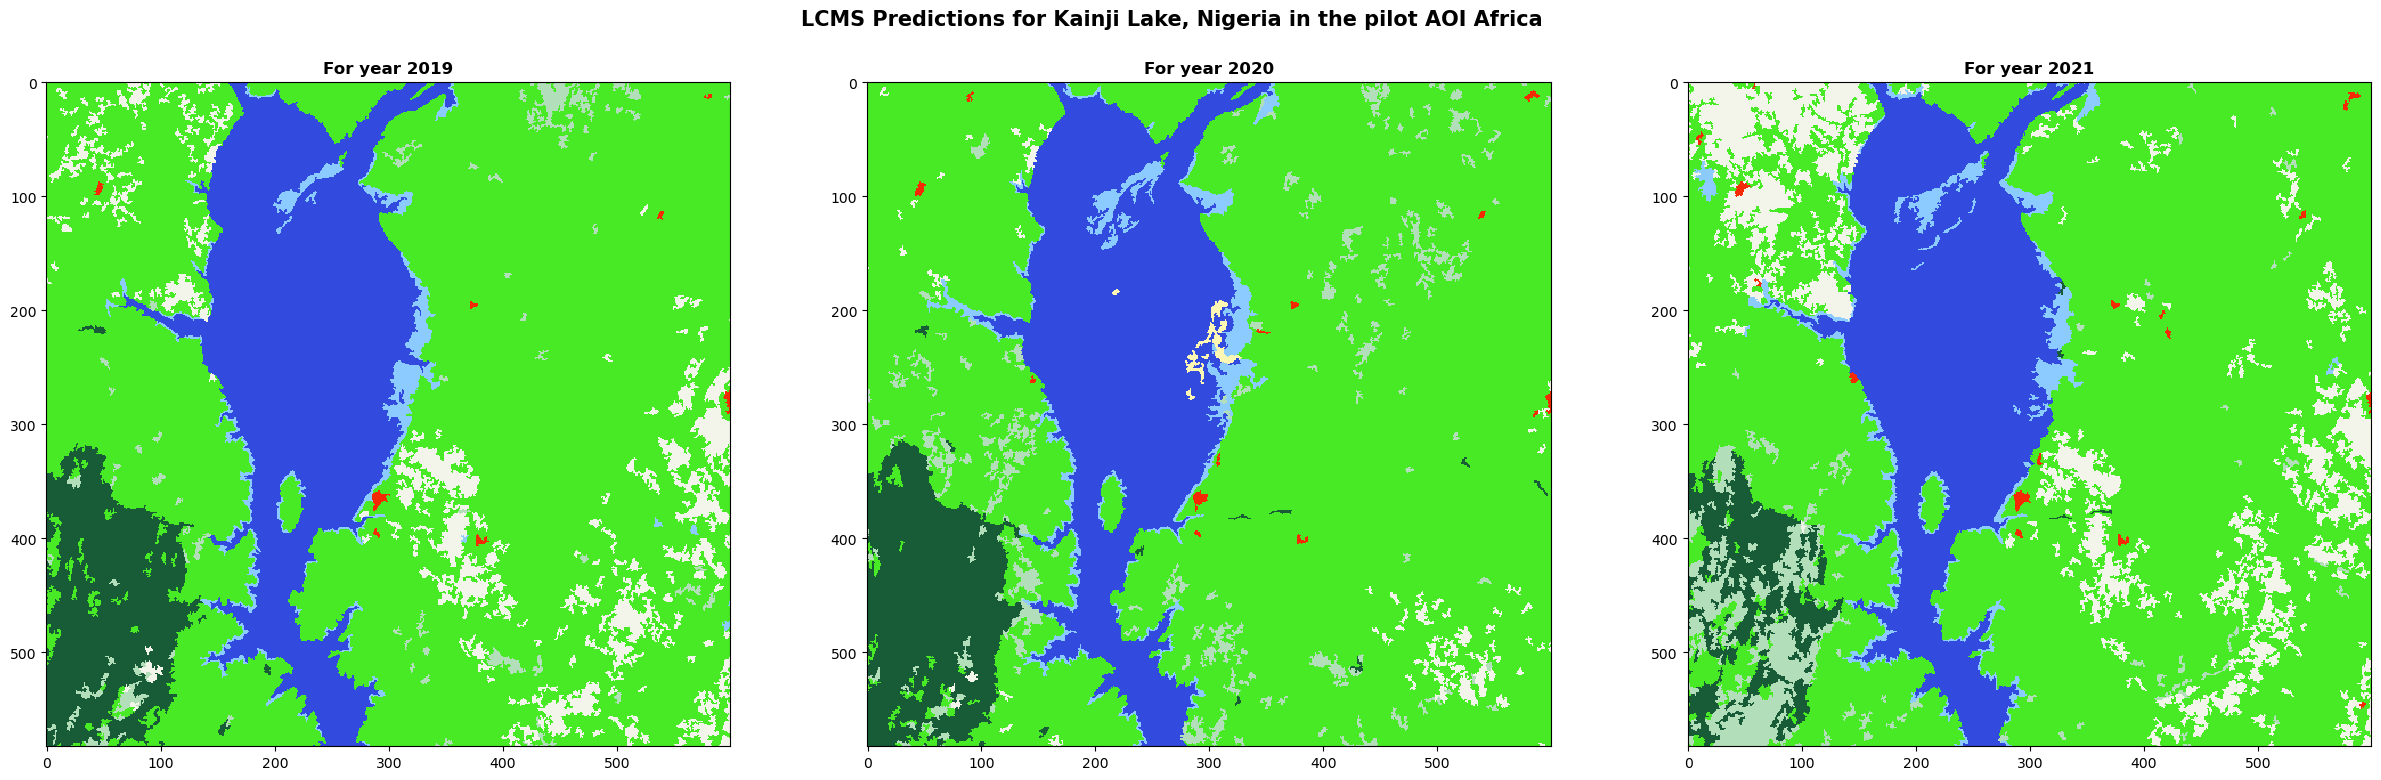

In [6]:
# Generate a plot for each year 
#  we visualize the predictions using transform_to_rgb function
preds_data = eopatch.data["lcms_pred"].astype(int).squeeze(axis=0)
y2019_preds = preds_data[:, :, 0]
y2020_preds = preds_data[:, :, 1]
y2021_preds = preds_data[:, :, 2]

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
ax1, ax2, ax3 = axes
ax1.set_title("For year 2019", fontweight="bold")
ax1.imshow(transform_to_rgb(y2019_preds),interpolation="nearest")
ax2.set_title("For year 2020", fontweight="bold")
ax2.imshow(transform_to_rgb(y2020_preds),interpolation="nearest")
ax3.set_title("For year 2021", fontweight="bold")
ax3.imshow(transform_to_rgb(y2021_preds),interpolation="nearest")
plt.suptitle("LCMS Predictions for Kainji Lake, Nigeria in the pilot AOI Africa", y=0.9, fontweight="bold", fontsize=15)

## Detecting Change b/w generated predictions
In the following code snippets, how we can visualize the changed pixels over the years. </br>
We used this technique to identify the regions which changed at lower resolutions. And together with **drill down mechanism** we identify changed regions using clustering techniques, and then only process limited regions at higher resolutions to reduce costs significantly.

In [7]:
# Similarly, we can visualize the data mask
def get_pred_diff(preds_from, preds_to):
    """
    This function generates the diff between the the LC-CMS predictions taken over two different time periods.
    """
    return np.where(preds_from != preds_to, preds_to, 0)

Text(0.5, 0.9, 'LCMS Predictions Delta (2-year change) for the Kainji Lake, Nigeria from 2019 to 2021 with various combinations')

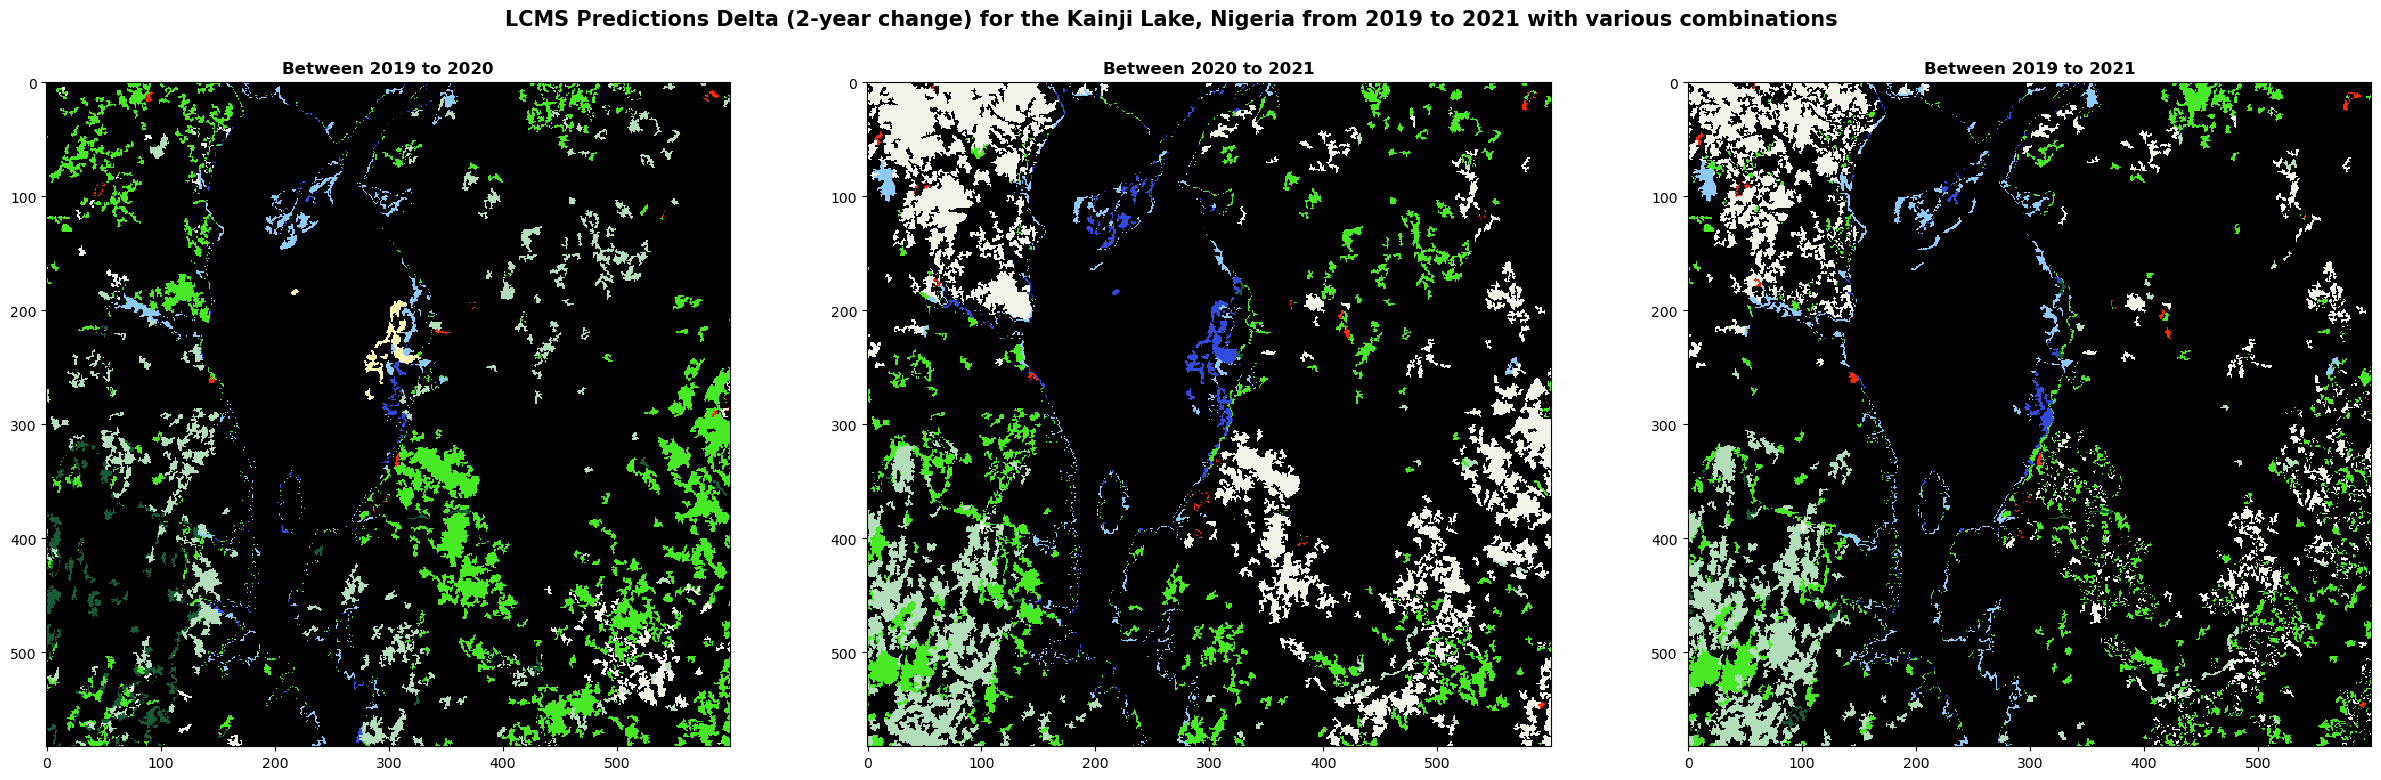

In [8]:
preds_data = eopatch.data["lcms_pred"].astype(int).squeeze(axis=0)
y2019_preds = preds_data[:, :, 0]
y2020_preds = preds_data[:, :, 1]
y2021_preds = preds_data[:, :, 2]

diff_2019_2020 = get_pred_diff(y2019_preds, y2020_preds)
diff_2020_2021 = get_pred_diff(y2020_preds, y2021_preds)
diff_2019_2021 = get_pred_diff(y2019_preds, y2021_preds)

# finally, we visualize the predictions using transform_to_rgb function
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
ax1, ax2, ax3 = axes
ax1.set_title("Between 2019 to 2020", fontweight="bold")
ax1.imshow(transform_to_rgb(diff_2019_2020),interpolation="nearest")
ax2.set_title("Between 2020 to 2021", fontweight="bold")
ax2.imshow(transform_to_rgb(diff_2020_2021),interpolation="nearest")
ax3.set_title("Between 2019 to 2021", fontweight="bold")
ax3.imshow(transform_to_rgb(diff_2019_2021),interpolation="nearest")
# plt.suptitle('LC-CMS Predictions for Nigeration in the pilot AOI Africa for years 2019, 2020, 2021')
plt.suptitle("LCMS Predictions Delta (2-year change) for the Kainji Lake, Nigeria from 2019 to 2021 with various combinations", y=0.9, fontweight="bold", fontsize=15)

### Interpreting Change Detection
The above image shows one of the techniques which can be used to identity change over a period of time. <br/>
Here we take a diff or delta between predictions of previous year and next year.  </br>
All the colors represent the final class which the class changed to, and black represents no change at all.

# Predictions over experiment AOI of France
In the following code snippets, we will see how we can access the data for the France AOI. </br>
France AOI was primariliy used for experimentation and model tuning. </br>

The final predictions that we will see were generated using following input data and modelling technique : </br>
**Input Data**
- Sentinel-2 L2A : Bands B1 to B12
- 120m with bilinear resampling​
- Sub-regions (AOIs) with different biomes and geographies 
- Yearly data aggregated every two months
- Predictions generated yearly

**Model**
- Pixel Based Classification using Random Forest Classifier
- 9 Classes

**We fetch the data first for all three resolutions i.e. 120m, 60m and 20m.**

In [9]:
# Create a bounding box where to request the data
paris_bbox = BBox((422500.0, 5420900.0, 439100.0, 5432400.0), CRS.UTM_31N)

In [10]:
# Download for 120m resolution
# The data for three years are stored as separate bands with following band names
resolution = 120
band_names = ["B1"]
collection_id = "59b4de97-ad51-47b0-80f6-c6c47fae1ca7"
lcms_preds_byoc = DataCollection.define_byoc(
    collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

# Create a task that will download the data from the BYOC service
predictions_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "lcms_pred"),
    data_collection=lcms_preds_byoc,
    bands=band_names,
    resolution=resolution,
    max_threads=3,
)

eopatch_paris = predictions_download_task.execute(bbox=paris_bbox) #, time_interval=["2019-01-01", "2023-01-01"]
paris_120m = eopatch_paris.data["lcms_pred"].astype(int).squeeze(axis=0)

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'lcms_pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


In [11]:
# Download for 60m resolution
resolution = 60
band_names = ["B1"]
collection_id = "5c21b111-07d2-43a3-95ad-46381c6e199a"
lcms_preds_byoc = DataCollection.define_byoc(
    collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

# Create a task that will download the data from the BYOC service
predictions_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "lcms_pred"),
    data_collection=lcms_preds_byoc,
    bands=band_names,
    resolution=resolution,
    max_threads=3,
)

eopatch_paris = predictions_download_task.execute(bbox=paris_bbox) #, time_interval=["2019-01-01", "2023-01-01"]
paris_60m = eopatch_paris.data["lcms_pred"].astype(int).squeeze(axis=0)

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'lcms_pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


In [12]:
# Download for 20m resolution
resolution = 20
band_names = ["B1"]
collection_id = "5c21b111-07d2-43a3-95ad-46381c6e199a"
lcms_preds_byoc = DataCollection.define_byoc(
    collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

# Create a task that will download the data from the BYOC service
predictions_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "lcms_pred"),
    data_collection=lcms_preds_byoc,
    bands=band_names,
    resolution=resolution,
    max_threads=3,
)

eopatch_paris = predictions_download_task.execute(bbox=paris_bbox) #, time_interval=["2019-01-01", "2023-01-01"]
paris_20m = eopatch_paris.data["lcms_pred"].astype(int).squeeze(axis=0)

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'lcms_pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


### Visualize predictions in France
Finally, here we visualize all the data together to see differences in resolutions and prediction quality.

Text(0.5, 0.8, 'LCMS Predictions for Paris region in France AOI for different resolutions')

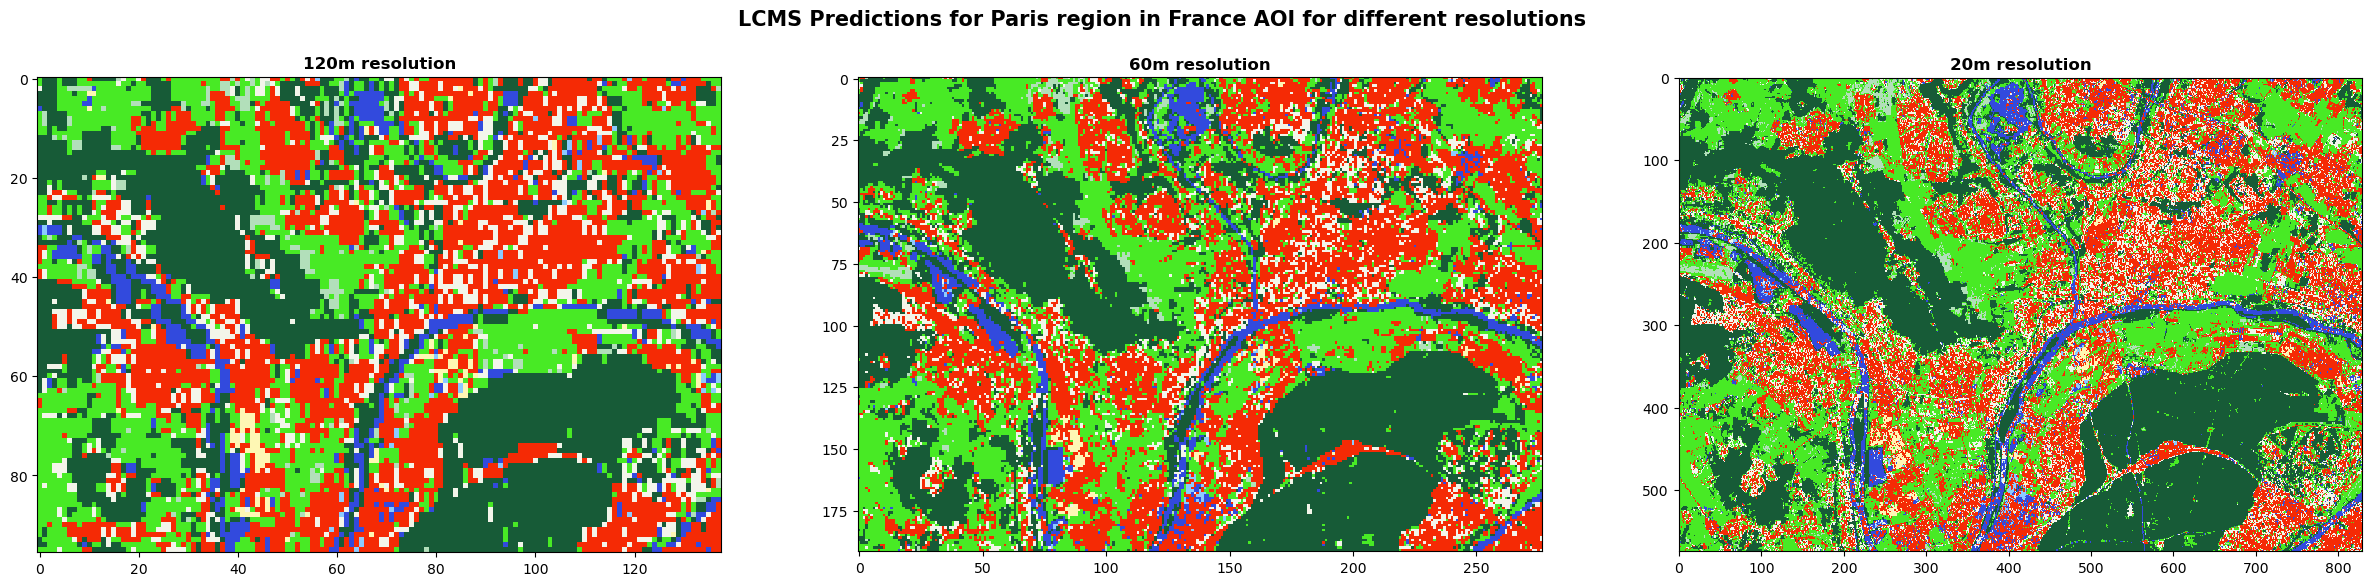

In [13]:
# finally, we visualize the predictions using transform_to_rgb function
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
ax1, ax2, ax3 = axes
ax1.set_title("120m resolution", fontweight="bold")
ax1.imshow(transform_to_rgb(paris_120m.squeeze(-1)),interpolation="nearest")
ax2.set_title("60m resolution", fontweight="bold")
ax2.imshow(transform_to_rgb(paris_60m.squeeze(-1)),interpolation="nearest")
ax3.set_title("20m resolution", fontweight="bold")
ax3.imshow(transform_to_rgb(paris_20m.squeeze(-1)),interpolation="nearest")
plt.suptitle("LCMS Predictions for Paris region in France AOI for different resolutions", y=0.8, fontweight="bold", fontsize=15)